# Цель работы

Исследование методов анализа ассоциативных правил.

# Первичаня обработка файла

Сперва преобразуем формат данных файла groceries.csv 

In [100]:
import csv

with open('groceries.csv', newline='', encoding='utf-8') as infile:
    reader = csv.reader(infile)
    data = list(reader)

max_len = max(len([item.strip() for item in row if item.strip() != '']) for row in data)

header = ['Item(s)'] + [f'Item {i+1}' for i in range(max_len)]

transformed_data = [header]

for row in data:
    products = [item.strip() for item in row if item.strip() != '']
    count = len(products)
    new_row = [count] + products
    new_row.extend([''] * (len(header) - len(new_row)))
    transformed_data.append(new_row)

with open('groceries_transformed.csv', 'w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile)
    writer.writerows(transformed_data)

print("Первые строки преобразованного файла:")
for row in transformed_data[:5]:
    print(row)


Первые строки преобразованного файла:
['Item(s)', 'Item 1', 'Item 2', 'Item 3', 'Item 4', 'Item 5', 'Item 6', 'Item 7', 'Item 8', 'Item 9', 'Item 10', 'Item 11', 'Item 12', 'Item 13', 'Item 14', 'Item 15', 'Item 16', 'Item 17', 'Item 18', 'Item 19', 'Item 20', 'Item 21', 'Item 22', 'Item 23', 'Item 24', 'Item 25', 'Item 26', 'Item 27', 'Item 28', 'Item 29', 'Item 30', 'Item 31', 'Item 32']
[4, 'citrus fruit', 'semi-finished bread', 'margarine', 'ready soups', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[3, 'tropical fruit', 'yogurt', 'coffee', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[1, 'whole milk', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[4, 'pip fruit', 'yogurt', 'cream cheese', 'meat spreads', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

# Распределение длин транзакций и товары с большой поддержкой

   Item(s)            Item 1               Item 2          Item 3  \
0        4      citrus fruit  semi-finished bread       margarine   
1        3    tropical fruit               yogurt          coffee   
2        1        whole milk                  NaN             NaN   
3        4         pip fruit               yogurt    cream cheese   
4        4  other vegetables           whole milk  condensed milk   

                     Item 4 Item 5 Item 6 Item 7 Item 8 Item 9  ... Item 23  \
0               ready soups    NaN    NaN    NaN    NaN    NaN  ...     NaN   
1                       NaN    NaN    NaN    NaN    NaN    NaN  ...     NaN   
2                       NaN    NaN    NaN    NaN    NaN    NaN  ...     NaN   
3              meat spreads    NaN    NaN    NaN    NaN    NaN  ...     NaN   
4  long life bakery product    NaN    NaN    NaN    NaN    NaN  ...     NaN   

  Item 24 Item 25 Item 26 Item 27 Item 28 Item 29 Item 30 Item 31 Item 32  
0     NaN     NaN     NaN     NaN 

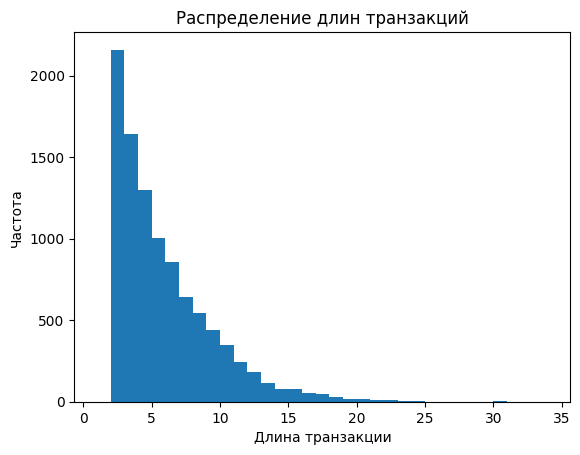

Уникальных товаров: 169


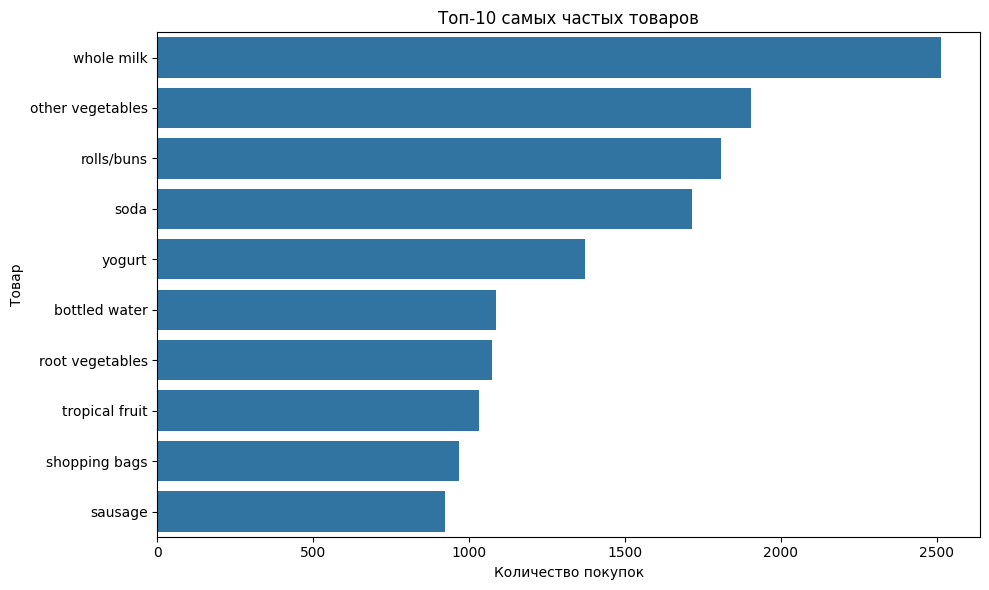

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

#Загрузка данных
all_data = pd.read_csv('groceries_transformed.csv')
print(all_data.head())

#Анализ транзакций
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

#Очистка данных
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

#Список уникальных товаров
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(f"Уникальных товаров: {len(unique_items)}")

te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

all_items = [item for row in np_data for item in row]
item_counts = Counter(all_items)
top_items = item_counts.most_common(10)
items, counts = zip(*top_items)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(items))
plt.title('Топ-10 самых частых товаров')
plt.xlabel('Количество покупок')
plt.ylabel('Товар')
plt.tight_layout()
plt.show()



# Apriori

**Описание алгоритма**

Классический алгоритм поиска ассоциативных правил и частых наборов в транзакционных данных.

**Принцип работы:**
- Использует свойство анти-монотонности: если набор не является частым, то ни одно из его надмножеств частым быть не может
- Многоэтапный процесс генерации кандидатов и проверки поддержки

**Алгоритм:**
1. Находит все частые одиночные товары (itemsets) по порогу поддержки (min_support)
2. Генерирует кандидатов размером k+1 на основе частых наборов размера k
3. Оставляет только те, что по-прежнему частые
4. Повторяет, пока не закончатся новые кандидаты
5. На втором этапе строит ассоциативные правила с порогом достоверности (min_confidence)

**Особенности:**
- Хорошо работает для небольших наборов данных
- Требует много ресурсов при большом числе уникальных товаров
- На каждом шаге проходит по всей базе транзакций для подсчёта поддержки кандидатов

Частые наборы
     support                         itemsets
57  0.255516                     (whole milk)
39  0.193493               (other vegetables)
43  0.183935                     (rolls/buns)
49  0.174377                           (soda)
58  0.139502                         (yogurt)
..       ...                              ...
75  0.020539        (whole milk, frankfurter)
60  0.020437       (whole milk, bottled beer)
76  0.020437  (whole milk, frozen vegetables)
96  0.020437      (tropical fruit, pip fruit)
67  0.020031       (other vegetables, butter)

[122 rows x 2 columns]
Количество найденных правил с достоверностью 0.13: 103
             antecedents         consequents   support  confidence      lift
0     (other vegetables)        (whole milk)  0.074835    0.386758  1.513634
1           (whole milk)  (other vegetables)  0.074835    0.292877  1.513634
2           (whole milk)        (rolls/buns)  0.056634    0.221647  1.205032
3           (rolls/buns)        (whole milk)  0

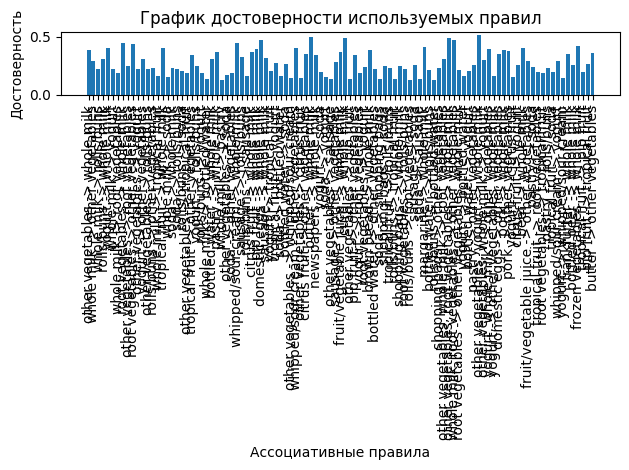

In [66]:
df1 = apriori(data, min_support=0.02, use_colnames = True)
df1 = df1.sort_values(by='support', ascending=False)
print("Частые наборы")
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.13)
print(f"Количество найденных правил с достоверностью 0.13: {len(rules)}")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
#График достоверности используемых правил
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Согласно результатам анализа частых наборов, самый востребованный товар — это цельное молоко (whole milk), которое составляет 25.6% всех транзакций. Наименее популярным сочетанием оказалось "овощи" и "масло" (other vegetables, butter), поддержка которого равна 0.02.

Применение алгоритма с заданной по варианту достоверностью позволило выявить 103 ассоциативных правила.

In [67]:
rules_lift = rules.sort_values(by='lift', ascending=False)
print("Правила с высоким lift (первые 10):")
print(rules_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

rules_conf = rules.sort_values(by='confidence', ascending=False)
print("\nПравила с высокой confidence (первые 10):")
print(rules_conf[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Правила с высоким lift (первые 10):
                      antecedents                   consequents   support  \
75                root vegetables  other vegetables, whole milk  0.023183   
72   other vegetables, whole milk               root vegetables  0.023183   
101                     pip fruit                tropical fruit  0.020437   
100                tropical fruit                     pip fruit  0.020437   
74    whole milk, root vegetables              other vegetables  0.023183   
8                other vegetables               root vegetables  0.047382   
9                 root vegetables              other vegetables  0.047382   
82                         yogurt  other vegetables, whole milk  0.022267   
80   other vegetables, whole milk                        yogurt  0.022267   
42             whipped/sour cream              other vegetables  0.028876   

     confidence      lift  
75     0.212687  2.842082  
72     0.309783  2.842082  
101    0.270161  2.574648  
100 

Наиболее значимые полезные правила:
1. (root vegetables) → (other vegetables, whole milk)

- Lift = 2.84 (самый высокий)

- Support = 2.3%

- Confidence = 21.3%

Покупатели корнеплодов с очень высокой вероятностью также покупают другие овощи и молоко

2. (tropical fruit) ↔ (pip fruit) (взаимная связь)

- Lift = 2.57

- Support = 2.0%

- Confidence = 19.5-27.0%

Сильная взаимосвязь между тропическими и косточковыми фруктами

3. (whole milk, root vegetables) → (other vegetables)

- Lift = 2.45

- Confidence = 47.4%

Комбинация молока и корнеплодов сильно предсказывает покупку других овощей и наоборот

4. Тривиальные правила: Правила с whole milk как консеквентом:

(butter) → (whole milk): Lift = 1.95, Confidence = 49.7%

(curd) → (whole milk): Lift = 1.92, Confidence = 49.0%

(domestic eggs) → (whole milk): Lift = 1.85, Confidence = 47.3%

Причина: Молоко - базовый товар, который часто покупается со многими другими, особенно молочными продуктами

3 самых полезных правила:

Овощные комбинации: корнеплоды → другие овощи + молоко

Фруктовые пары: тропические ↔ косточковые фрукты

Молочные комплексы: йогурт + овощи → молоко

In [68]:
import numpy as np

supports = np.arange(0.01, 0.20, 0.01)  

min_supports = {} 

for sup in supports:
    freq_sets = apriori(data, min_support=sup, use_colnames=True)
    if freq_sets.empty:
        continue

    freq_sets["length"] = freq_sets["itemsets"].apply(len)
    
    for length in sorted(freq_sets["length"].unique()):
        if length not in min_supports:
            min_supports[length] = sup

min_supports_df = pd.DataFrame(list(min_supports.items()), columns=["Длина набора (кол-во элементов)", "Минимальный support"])
min_supports_df = min_supports_df.sort_values("Длина набора (кол-во элементов)")
print("Минимальные значения поддержки для появления наборов разной длины:")
print(min_supports_df)

Минимальные значения поддержки для появления наборов разной длины:
   Длина набора (кол-во элементов)  Минимальный support
0                                1                 0.01
1                                2                 0.01
2                                3                 0.01


## Оценка влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

   support  confidence  num_rules  avg_confidence  avg_lift
0     0.01        0.25        170        0.370332  1.874660
1     0.01        0.35         89        0.437193  1.937262
2     0.01        0.40         62        0.464345  1.993455
3     0.02        0.25         49        0.362910  1.723817
4     0.02        0.35         26        0.418250  1.771844
5     0.02        0.40         15        0.448026  1.863106
6     0.03        0.25         15        0.370359  1.598017
7     0.03        0.35          9        0.407180  1.654151
8     0.03        0.40          5        0.427549  1.782344


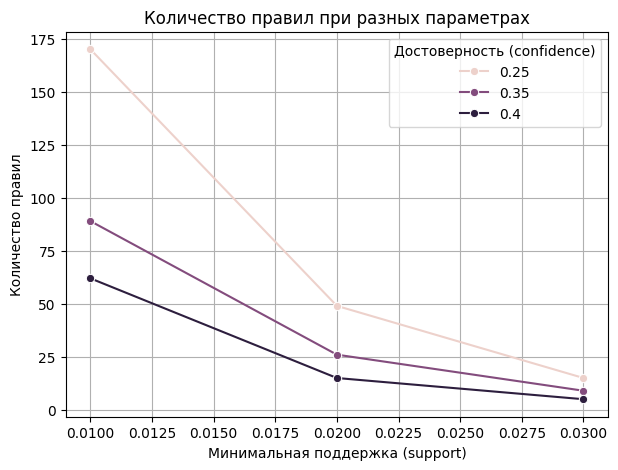

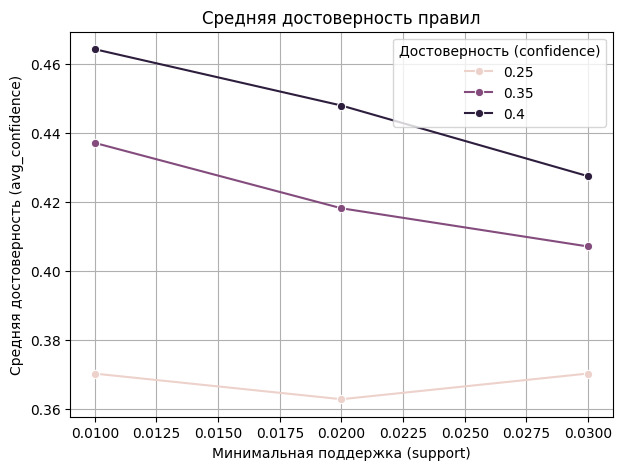

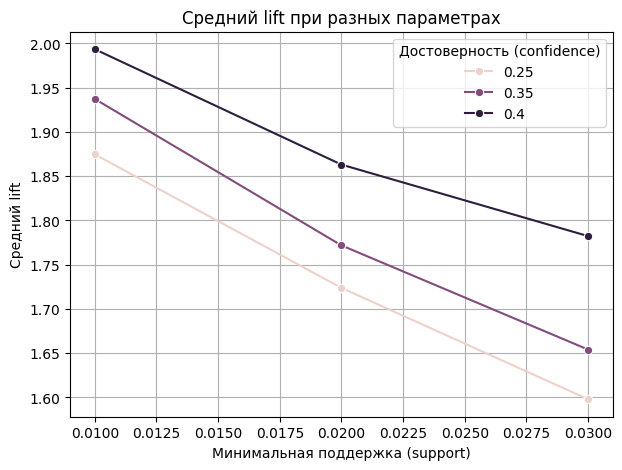

In [69]:
results = []
supports = [0.01, 0.02, 0.03]
confidences = [0.25, 0.35, 0.4]

for sup in supports:
    for conf in confidences:
        freq_items = apriori(data, min_support=sup, use_colnames=True)
        rule_set = association_rules(freq_items, metric="confidence", min_threshold=conf)

        num_rules = len(rule_set)
        avg_confidence = rule_set['confidence'].mean() if num_rules > 0 else 0
        avg_lift = rule_set['lift'].mean() if num_rules > 0 else 0
        useful_rules = len(rule_set[rule_set['lift'] > 1])

        results.append({
            'support': sup,
            'confidence': conf,
            'num_rules': num_rules,
            'avg_confidence': avg_confidence,
            'avg_lift': avg_lift,
        })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(7,5))
sns.lineplot(data=results_df, x='support', y='num_rules', hue='confidence', marker='o')
plt.title('Количество правил при разных параметрах')
plt.xlabel('Минимальная поддержка (support)')
plt.ylabel('Количество правил')
plt.legend(title='Достоверность (confidence)')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
sns.lineplot(data=results_df, x='support', y='avg_confidence', hue='confidence', marker='o')
plt.title('Средняя достоверность правил')
plt.xlabel('Минимальная поддержка (support)')
plt.ylabel('Средняя достоверность (avg_confidence)')
plt.legend(title='Достоверность (confidence)')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
sns.lineplot(data=results_df, x='support', y='avg_lift', hue='confidence', marker='o')
plt.title('Средний lift при разных параметрах')
plt.xlabel('Минимальная поддержка (support)')
plt.ylabel('Средний lift')
plt.legend(title='Достоверность (confidence)')
plt.grid(True)
plt.show()

## Анализ результатов

### Влияние support

- При увеличении support (с 0.01 до 0.03) количество правил (num_rules) резко уменьшается.  
  Это связано с тем, что более высокий порог поддержки исключает редкие (не всегда тривиальные) сочетания товаров.  
- Средняя достоверность (avg_confidence) при этом немного падает.  
- Средний lift имеет тенденцию к снижению, поскольку редкие, но сильные связи отбрасываются при высоком support.



### Влияние confidence

- При увеличении порога достоверности (confidence) для фиксированного уровня support наблюдается уменьшение количества правил.  
  При support = 0.01: количество правил снижается со 170 до 62.  
- Средняя достоверность закономерно растёт, а lift также имеет тенденцию к увеличению — остаются только более сильные и надёжные зависимости.  



### Совместный эффект параметров

| Тенденция | При росте support | При росте confidence |
|------------|--------------------|-------------------------|
| Количество правил (num_rules) | резко уменьшается | уменьшается |
| Средняя достоверность (avg_confidence) | немного падает | значительно растёт |
| Средний lift (avg_lift) | падает | немного растёт |



### Общий вывод

- Низкая минимальная поддержка и умеренная достоверность позволяют получить больше правил, включая слабые, но потенциально интересные.  
- Более высокий support и confidence приводят к меньшему количеству, но более надёжных и интерпретируемых правил.  

Таким образом, выбор оптимальных параметров зависит от цели анализа:
- Для исследовательского анализа: support = 0.01–0.02, confidence = 0.25–0.3;
- Для поиска устойчивых закономерностей: support = 0.02–0.03, confidence = 0.35–0.4.

# FPG

**Описание алгоритма**

Современный, более быстрый алгоритм поиска частых наборов и ассоциативных правил.

**Принцип работы:**
- Вместо генерации кандидатов строит компактное дерево частых паттернов (FP-дерево)
- Уменьшает число проходов по данным за счёт эффективной структуры хранения

**Алгоритм:**
1. За один проход определяет поддерживаемые товары, строит из них FP-tree (дерево "путь покупки")
2. Рекурсивно извлекает все частые наборы, минуя явную генерацию всех кандидатов
3. После этого строит правила как и в Apriori

**Особенности:**
- Значительно быстрее Apriori на больших объемах данных
- Эффективен при большом количестве уникальных позиций
- Меньше требует памяти благодаря компактной структуре дерева
- Повторяющиеся паттерны хранятся объединённо
- Чаще используется в современных инструментах анализа покупательских корзин

Частые наборы
      support                         itemsets
5    0.255516                     (whole milk)
8    0.193493               (other vegetables)
11   0.183935                     (rolls/buns)
19   0.174377                           (soda)
2    0.139502                         (yogurt)
..        ...                              ...
93   0.020539        (whole milk, frankfurter)
82   0.020437       (whole milk, bottled beer)
75   0.020437      (tropical fruit, pip fruit)
121  0.020437  (whole milk, frozen vegetables)
79   0.020031       (other vegetables, butter)

[122 rows x 2 columns]
Количество найденных правил с достоверностью 0.13: 103
             antecedents         consequents   support  confidence      lift
0     (other vegetables)        (whole milk)  0.074835    0.386758  1.513634
1           (whole milk)  (other vegetables)  0.074835    0.292877  1.513634
2           (whole milk)        (rolls/buns)  0.056634    0.221647  1.205032
3           (rolls/buns)        (wh

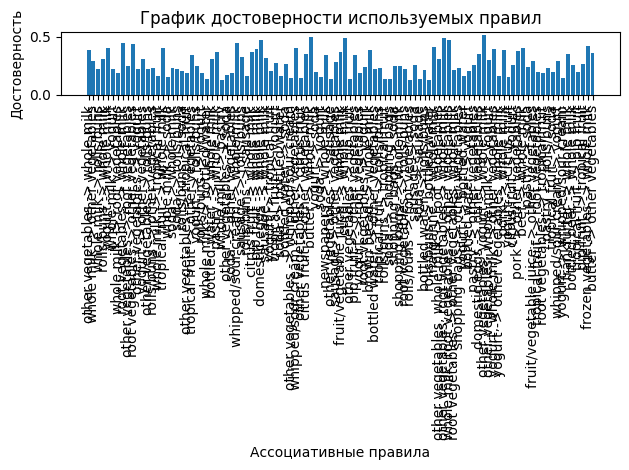

In [70]:
df1 = fpgrowth(data, min_support=0.02, use_colnames = True)
df1 = df1.sort_values(by='support', ascending=False)
print("Частые наборы")
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.13)
print(f"Количество найденных правил с достоверностью 0.13: {len(rules)}")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
#График достоверности используемых правил
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Результат по выявлению частых наборов, очевидно, идентичен выводу с использованием алгоритма apriori. 

Наиболее частые товары/наборы:

- "whole milk" (молоко) — входит в 25% всех транзакций.

- "other vegetables" (другие овощи) — встречаются почти в 20%.

- Далее, часто встречаются хлебобулочные изделия (rolls/buns), soda, yogurt и их сочетания.

молоко и овощи — универсальные продукты, их часто покупают в разных целях и для разных блюд.



**Интерпретация ассоциативных правил**

Много правил с участием универсальных продуктов ― молоко, овощи, хлеб, йогурт, фрукты. Это объясняет их частое совместное появление благодаря универсальности и употреблению в разных приёмах пищи/рецептах.

Высокий confidence — 39–49%: есть продукты и группы, которые очень часто встречаются в комплекте, и их покупка друг с другом закономерна.

Lift обычно выше 1,2-1,8, иногда выше 2,5. Это уверенные ассоциации: товары куплены вместе значительно чаще, чем при случайном выборе. Значения lift выше 2 особенно важны — это не случайные, а действительно осмысленные паттерны покупок.

In [71]:
import numpy as np

supports = np.arange(0.01, 0.20, 0.01)  

min_supports = {} 

for sup in supports:
    freq_sets = fpgrowth(data, min_support=sup, use_colnames=True)
    if freq_sets.empty:
        continue

    freq_sets["length"] = freq_sets["itemsets"].apply(len)
    
    for length in sorted(freq_sets["length"].unique()):
        if length not in min_supports:
            min_supports[length] = sup

min_supports_df = pd.DataFrame(list(min_supports.items()), columns=["Длина набора (кол-во элементов)", "Минимальный support"])
min_supports_df = min_supports_df.sort_values("Длина набора (кол-во элементов)")
print("Минимальные значения поддержки для появления наборов разной длины:")
print(min_supports_df)

Минимальные значения поддержки для появления наборов разной длины:
   Длина набора (кол-во элементов)  Минимальный support
0                                1                 0.01
1                                2                 0.01
2                                3                 0.01


Результаты эксперимента:


,support,confidence,num_rules,avg_confidence,avg_lift
0,0.01,0.2,234,0.330841,1.805114
1,0.01,0.3,125,0.405788,1.905986
2,0.01,0.4,62,0.464345,1.993455
3,0.02,0.2,73,0.318131,1.631356
4,0.02,0.3,37,0.391503,1.730191
5,0.02,0.4,15,0.448026,1.863106
6,0.03,0.2,25,0.312867,1.504996
7,0.03,0.3,14,0.375893,1.604045
8,0.03,0.4,5,0.427549,1.782344



Всего найдено правил: 590


,antecedents,consequents,support,confidence,lift,support_param,confidence_param
0,(citrus fruit),(whole milk),0.030503,0.368550,1.442377,0.01,0.2
1,(citrus fruit),(yogurt),0.021657,0.261671,1.875752,0.01,0.2
2,(citrus fruit),(tropical fruit),0.019929,0.240786,2.294702,0.01,0.2
3,(citrus fruit),(other vegetables),0.028876,0.348894,1.803140,0.01,0.2
4,(citrus fruit),(root vegetables),0.017692,0.213759,1.961121,0.01,0.2
...,...,...,...,...,...,...,...
585,(yogurt),(whole milk),0.056024,0.401603,1.571735,0.03,0.4
586,(tropical fruit),(whole milk),0.042298,0.403101,1.577595,0.03,0.4
587,(root vegetables),(other vegetables),0.047382,0.434701,2.246605,0.03,0.4
588,(root vegetables),(whole milk),0.048907,0.448694,1.756031,0.03,0.4


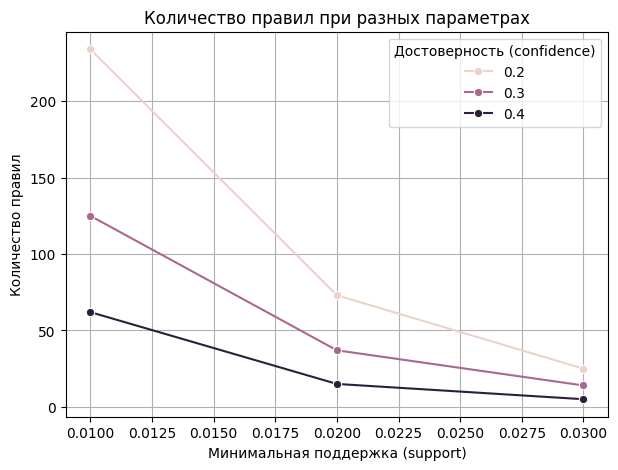

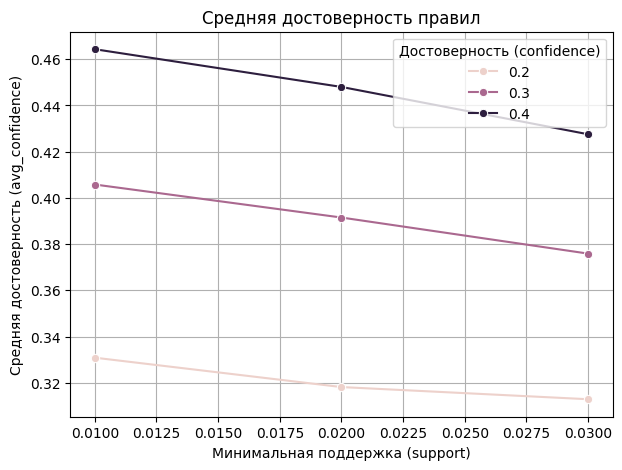

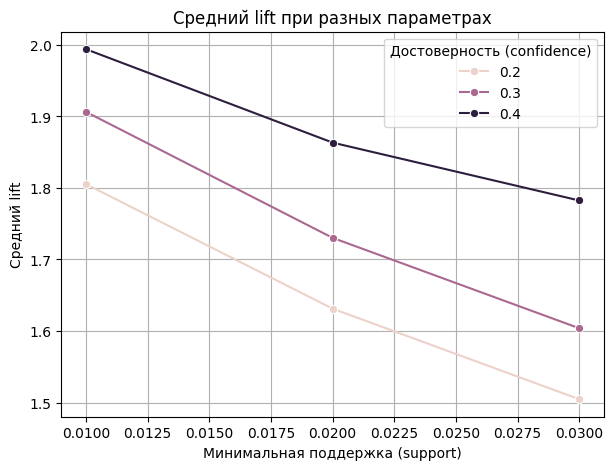

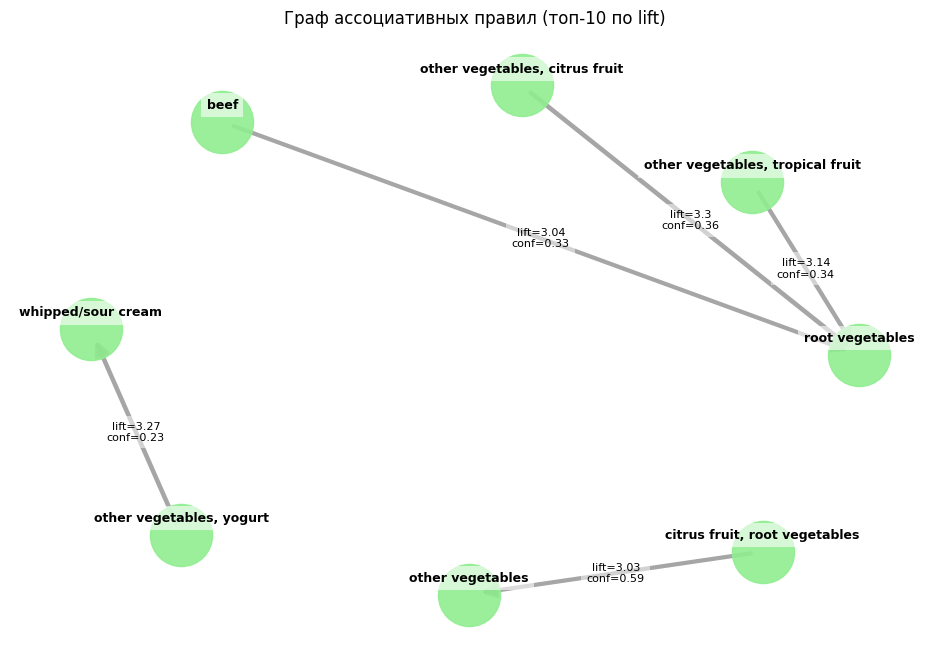

In [ ]:
import networkx as nx

supports = [0.01, 0.02, 0.03]
confidences = [0.2, 0.3, 0.4]
results = []
all_rules = [] 

for sup in supports:
    freq_items = fpgrowth(data, min_support=sup, use_colnames=True)
    if freq_items.empty:
        print(f"При support={sup} не найдено частых наборов.")
        continue

    for conf in confidences:
        rules = association_rules(freq_items, metric="confidence", min_threshold=conf)

        num_rules = len(rules)
        avg_conf = rules['confidence'].mean() if num_rules > 0 else 0
        avg_lift = rules['lift'].mean() if num_rules > 0 else 0

        if num_rules > 0:
            rules['support_param'] = sup
            rules['confidence_param'] = conf
            all_rules.append(rules)

        results.append({
            'support': sup,
            'confidence': conf,
            'num_rules': num_rules,
            'avg_confidence': avg_conf,
            'avg_lift': avg_lift
        })

results_df = pd.DataFrame(results)
print("Результаты эксперимента:")
display(results_df)

if all_rules:
    all_rules_df = pd.concat(all_rules, ignore_index=True)
    print(f"\nВсего найдено правил: {len(all_rules_df)}")
    display(all_rules_df[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'support_param', 'confidence_param']])
else:
    print("равила не найдены при заданных параметрах.")
    all_rules_df = pd.DataFrame()

plt.figure(figsize=(7,5))
sns.lineplot(data=results_df, x='support', y='num_rules', hue='confidence', marker='o')
plt.title('Количество правил при разных параметрах')
plt.xlabel('Минимальная поддержка (support)')
plt.ylabel('Количество правил')
plt.legend(title='Достоверность (confidence)')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
sns.lineplot(data=results_df, x='support', y='avg_confidence', hue='confidence', marker='o')
plt.title('Средняя достоверность правил')
plt.xlabel('Минимальная поддержка (support)')
plt.ylabel('Средняя достоверность (avg_confidence)')
plt.legend(title='Достоверность (confidence)')
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
sns.lineplot(data=results_df, x='support', y='avg_lift', hue='confidence', marker='o')
plt.title('Средний lift при разных параметрах')
plt.xlabel('Минимальная поддержка (support)')
plt.ylabel('Средний lift')
plt.legend(title='Достоверность (confidence)')
plt.grid(True)
plt.show()

if not all_rules_df.empty:

    top_rules = all_rules_df.nlargest(10, 'lift')

    G = nx.DiGraph()

    for _, row in top_rules.iterrows():
        antecedents = ', '.join(list(row['antecedents']))
        consequents = ', '.join(list(row['consequents']))
        lift = round(row['lift'], 2)
        conf = round(row['confidence'], 2)

        G.add_edge(antecedents, consequents, weight=lift, label=f"lift={lift}\nconf={conf}")

    plt.figure(figsize=(12,8))
    
    pos = nx.spring_layout(G, k=4.0, iterations=50, seed=42)
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=2000, alpha=0.9)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, width=edge_weights, edge_color='gray', alpha=0.7)

    for node, (x, y) in pos.items():
        plt.text(x, y+0.05, s=node, horizontalalignment='center', fontweight='bold', fontsize=9, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5, rotate=False, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    plt.title("Граф ассоциативных правил (топ-10 по lift)")
    plt.axis('off')
    plt.show()

## Интерпретация результатов и графа

**Совместный эффект параметров**

| Показатель | При росте min_support | При росте confidence |
|------------|----------------------|--------------------------|
| Количество правил (num_rules) | **Сильно уменьшается** | **Уменьшается** |
| Средняя достоверность (avg_confidence) | **Снижается** (0.33 → 0.31 при confidence=0.2) | **Значительно растёт** (0.33 → 0.46 при support=0.01) |
| Средний lift (avg_lift) | **Снижается** (1.81 → 1.50 при confidence=0.2) | **Умеренно растёт** (1.81 → 1.99 при support=0.01) |

**Высокий lift** (3.0–3.3) говорит о том, что эти группы продуктов часто покупают вместе, намного чаще, чем если бы клиенты выбирали их случайно и независимо друг от друга. Это может быть связано с классическими блюдами (например, говядина и корнеплоды используют вместе в супах или рагу), схожестью сценариев употребления (например, “йогурт и сливки” — для завтрака/десерта), сезонными предпочтениями или типичными комплектами (несколько видов овощей и фрукты).​

**Confidence** показывает вероятность, что если в корзине клиента уже есть один товар (например, “other vegetables, yogurt”), то с какой долей вероятности там окажется и второй (“whipped/sour cream”). Если эта вероятность не очень высокая (0.23–0.36), это может говорить о том, что связь опосредованная: многие берут один из товаров, а второй — только иногда, возможно, по рецепту или из-за специальной акции. Если, наоборот, значение ближе к 0.6, значит связка встречается настолько часто, что, возможно, один товар “вытягивает” второй за собой по привычке или рецептуре.

**Причины таких ассоциативных правил**

- Кулинарная логика: определённые продукты нужны вместе для приготовления конкретных блюд (первые блюда, салаты, десерты).

- Схожий спрос: некоторые группы товаров просто часто покупают любые вместе — овощи, фрукты к столу.

- Комбинирование по акции: акции “купи X — получи скидку на Y” делают ассоциации искусственно сильнее.

- Пищевые привычки: завтрак/перекус (йогурт, сливки, овощи), обед (корнеплоды, например, картофель + мясо).

## Альтернативный способ визуализации

Для альтернативного способа визуализации предложена пузырьковая диаграмма, которая показывает:

- По оси X - Support (поддержка правила) в процентах

- По оси Y - Confidence (достоверность) в процентах

- Цвет пузырька -  показывает значение Lift (чем "теплее" цвет, тем выше лифт)

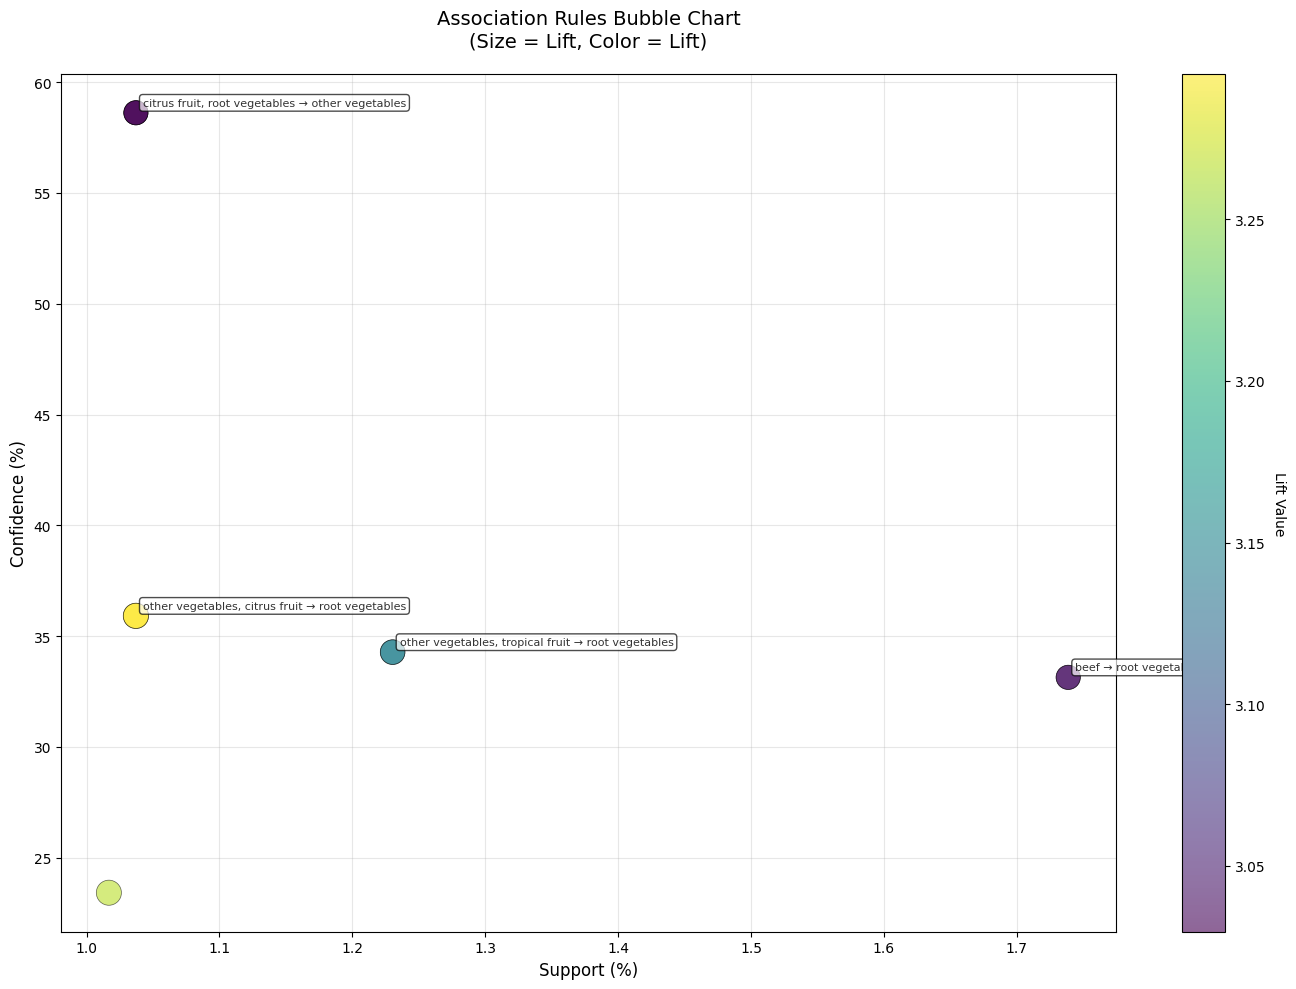

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_bubble_chart_association_rules(rules_df, top_n=30):
    
    top_rules = rules_df.nlargest(top_n, 'lift')
    
    support = top_rules['support'] * 100  
    confidence = top_rules['confidence'] * 100
    lift = top_rules['lift']
    
    rule_labels = []
    for _, rule in top_rules.iterrows():
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        label = f"{antecedents} → {consequents}"
        rule_labels.append(label)
    
    plt.figure(figsize=(14, 10))
    
    scatter = plt.scatter(support, confidence, 
                         s=lift*100,  
                         c=lift,     
                         alpha=0.6, 
                         cmap='viridis',
                         edgecolors='black', 
                         linewidth=0.5)
    
    for i, (x, y, label) in enumerate(zip(support, confidence, rule_labels)):
        if i % 3 == 0:  
            plt.annotate(label, (x, y), 
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=8,
                        alpha=0.8,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))
    
    plt.xlabel('Support (%)', fontsize=12)
    plt.ylabel('Confidence (%)', fontsize=12)
    plt.title('Association Rules Bubble Chart\n(Size = Lift, Color = Lift)', fontsize=14, pad=20)
    
    cbar = plt.colorbar(scatter)
    cbar.set_label('Lift Value', rotation=270, labelpad=15)
    
    plt.grid(True, alpha=0.3)
    
    sizes_legend = [1, 2, 3, 4, 5] 
    for size in sizes_legend:
        plt.scatter([], [], s=size*100, c='gray', alpha=0.6, 
                   label=f'Lift ≈ {size}', edgecolors='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

top_rules = all_rules_df.nlargest(10, 'lift')

plot_bubble_chart_association_rules(top_rules)

# Выводы

В ходе работы были реализованы и проанализированы алгоритмы поиска ассоциативных правил (Apriori, FP-growth) на транзакционных данных, подробно исследованы выводы по метрикам и структуре полученных правил, а также предложен альтернативный способ визуализации правил.

# Список источников

1. Метрики для поиска ассоциативных правил - https://habr.com/ru/companies/ods/articles/353502/
2. Описание алгоритма FPG - https://loginom.ru/blog/fpg#алгоритм-frequent-pattern-growth-strategy-fpg
3. Описание алгоритма Apriori - https://loginom.ru/blog/apriori